# Session 1: HPC and the Julia framework

## OBJECTIVE: Confirm Julia framework and Base speed

##### KR1: Use `@code_*` to examine a simple function. The `*` is replaceable by `native`, `typed`, `warntype`, and others. Discover them.

First, I want to look at the docs of each macro function:

In [1]:
?code_native

search: code_native @code_native



```
code_native([io=stdout,], f, types; syntax=:att, debuginfo=:default)
```

Prints the native assembly instructions generated for running the method matching the given generic function and type signature to `io`. Switch assembly syntax using `syntax` symbol parameter set to `:att` for AT&T syntax or `:intel` for Intel syntax. Keyword argument `debuginfo` may be one of source (default) or none, to specify the verbosity of code comments.


In [2]:
@code_native 10 / 2

	.section	__TEXT,__text,regular,pure_instructions
; ┌ @ int.jl:93 within `/'
; │┌ @ float.jl:206 within `float'
; ││┌ @ float.jl:191 within `AbstractFloat'
; │││┌ @ float.jl:94 within `Float64'
	vcvtsi2sd	%rdi, %xmm0, %xmm0
	vcvtsi2sd	%rsi, %xmm1, %xmm1
; │└└└
; │ @ int.jl:93 within `/' @ float.jl:335
	vdivsd	%xmm1, %xmm0, %xmm0
; │ @ int.jl:93 within `/'
	retq
; │ @ int.jl:93 within `<invalid>'
	nop
; └


In [3]:
?code_typed

search: code_typed @code_typed code_warntype @code_warntype



```
code_typed(f, types; optimize=true, debuginfo=:default)
```

Returns an array of type-inferred lowered form (IR) for the methods matching the given generic function and type signature. The keyword argument `optimize` controls whether additional optimizations, such as inlining, are also applied. The keyword `debuginfo` controls the amount of code metadata present in the output, possible options are `:source` or `:none`.


In [4]:
@code_typed 10 / 2

CodeInfo(
1 ─ %1 = Base.sitofp(Float64, x)::Float64
│   %2 = Base.sitofp(Float64, y)::Float64
│   %3 = Base.div_float(%1, %2)::Float64
└──      return %3
) => Float64

In [5]:
?code_warntype

search: code_warntype @code_warntype



```
code_warntype([io::IO], f, types; debuginfo=:default)
```

Prints lowered and type-inferred ASTs for the methods matching the given generic function and type signature to `io` which defaults to `stdout`. The ASTs are annotated in such a way as to cause "non-leaf" types to be emphasized (if color is available, displayed in red). This serves as a warning of potential type instability. Not all non-leaf types are particularly problematic for performance, so the results need to be used judiciously. In particular, unions containing either [`missing`](@ref) or [`nothing`](@ref) are displayed in yellow, since these are often intentional.

Keyword argument `debuginfo` may be one of `:source` or `:none` (default), to specify the verbosity of code comments.

See [`@code_warntype`](@ref man-code-warntype) for more information.


In [6]:
@code_warntype 10 / 2

Variables
  #self#::Core.Const(/)
  x::Int64
  y::Int64

Body::Float64
1 ─ %1 = Base.float(x)::Float64
│   %2 = Base.float(y)::Float64
│   %3 = (%1 / %2)::Float64
└──      return %3


In [7]:
?code_llvm

search: code_llvm @code_llvm



```
code_llvm([io=stdout,], f, types; raw=false, dump_module=false, optimize=true, debuginfo=:default)
```

Prints the LLVM bitcodes generated for running the method matching the given generic function and type signature to `io`.

If the `optimize` keyword is unset, the code will be shown before LLVM optimizations. All metadata and dbg.* calls are removed from the printed bitcode. For the full IR, set the `raw` keyword to true. To dump the entire module that encapsulates the function (with declarations), set the `dump_module` keyword to true. Keyword argument `debuginfo` may be one of source (default) or none, to specify the verbosity of code comments.


In [8]:
@code_llvm 10 / 2

;  @ int.jl:93 within `/'
define double @"julia_/_1801"(i64 signext %0, i64 signext %1) {
top:
; ┌ @ float.jl:206 within `float'
; │┌ @ float.jl:191 within `AbstractFloat'
; ││┌ @ float.jl:94 within `Float64'
     %2 = sitofp i64 %0 to double
     %3 = sitofp i64 %1 to double
; └└└
;  @ int.jl:93 within `/' @ float.jl:335
  %4 = fdiv double %2, %3
;  @ int.jl:93 within `/'
  ret double %4
}


In [9]:
@code_llvm 10.0 / 2.0

;  @ float.jl:335 within `/'
define double @"julia_/_1814"(double %0, double %1) {
top:
  %2 = fdiv double %0, %1
  ret double %2
}


What's interesting here is under the hood, if the inputs for division are not floats/doubles they're converted first.

Personally, among these macros `@code_warntype` is likely the one I'm going to use the most in the future.

##### KR2: Demonstrate that Julia is able to determine constants in codes.

Here we can see that the  euler constant is a constant inside the function (0x4005BF0A8B145769). 

In [10]:
f(x) = log(x) * ℯ

f (generic function with 1 method)

In [11]:
@code_llvm f(1.0)

;  @ In[10]:1 within `f'
define double @julia_f_1870(double %0) {
top:
  %1 = call double @j_log_1872(double %0)
; ┌ @ promotion.jl:322 within `*' @ float.jl:332
   %2 = fmul double %1, 0x4005BF0A8B145769
; └
  ret double %2
}


If we don't have a constant, we can see that it won't reflect in `@code_llvm`

In [12]:
g(x) = log(x) * x

g (generic function with 1 method)

In [13]:
@code_llvm g(1.0)

;  @ In[12]:1 within `g'
define double @julia_g_1897(double %0) {
top:
  %1 = call double @j_log_1899(double %0)
; ┌ @ float.jl:332 within `*'
   %2 = fmul double %1, %0
; └
  ret double %2
}


##### KR3: Demonstrate Julia's type-inference and multiple dispatch.

Following demo in class, to demonstrate multiple dispatch

In [14]:
what(x) = "$(x) is a $(typeof(x))" #most general case
what(x::String) = "$(x) is a string"
what(x::Number) = "$(x) is a number"
what(x::Real) = "$(x) is  real number"
what(x::Rational) = "$(x) is  rational number"
what(x::Int) = "$(x) is an integer"
what(x::Complex) = "$(x) is  complex number"

what (generic function with 7 methods)

In [15]:
?what

search: what Cwchar_t



No documentation found.

`what` is a `Function`.

```
# 7 methods for generic function "what":
[1] what(x::String) in Main at In[14]:2
[2] what(x::Rational) in Main at In[14]:5
[3] what(x::Int64) in Main at In[14]:6
[4] what(x::Real) in Main at In[14]:4
[5] what(x::Complex) in Main at In[14]:7
[6] what(x::Number) in Main at In[14]:3
[7] what(x) in Main at In[14]:1
```


Just to try a lot of things:

In [16]:
for x in [π, 1, 1.0, "x", 'x', 1+0im, 
          [1,2], ["x", "y"], ['x', 'y'], ["x", 'y'], [Int64(1), 1.0]]
    println(what(x))
end

π is  real number
1 is an integer
1.0 is  real number
x is a string
x is a Char
1 + 0im is  complex number
[1, 2] is a Vector{Int64}
["x", "y"] is a Vector{String}
['x', 'y'] is a Vector{Char}
Any["x", 'y'] is a Vector{Any}
[1.0, 1.0] is a Vector{Float64}


Vectors having specific typings that can be specified is interesting having never thought about this when I was primarily using Python before.

One other thing I have to wrap my head around in Julia is the subset of types. For example π in the previous output is a real number (which it is), but when we specifically call typeof on it, it's more specific(?): `Irrational`.

In [17]:
typeof(π)

Irrational{:π}

##### KR4: Show the difference, if any, between your own sum function `my_sum(x::Vector)` and `@time`. Use a `for`-loop for your *customized* sum function.

Unrelated to the KR but I realized here that Σ `\Sigma` is a different character here from ∑ `\Sum`

In [18]:
"""
    my_sum( x )
Return the sum of all elements in an input vector `x`
- Input: `x::Vector`
- Output: `Σ::Number`
"""
function my_sum(x::Vector)
    Σ = zero(eltype(x))
    for i in x
        Σ += i
    end
    return Σ
end

my_sum

In [19]:
?my_sum

search: my_sum



```
my_sum( x )
```

Return the sum of all elements in an input vector `x`

  * Input: `x::Vector`
  * Output: `Σ::Number`


In [20]:
?sum

search: sum sum! summary cumsum my_sum cumsum! isnumeric VersionNumber



```
sum(f, itr; [init])
```

Sum the results of calling function `f` on each element of `itr`.

The return type is `Int` for signed integers of less than system word size, and `UInt` for unsigned integers of less than system word size.  For all other arguments, a common return type is found to which all arguments are promoted.

The value returned for empty `itr` can be specified by `init`. It must be the additive identity (i.e. zero) as it is unspecified whether `init` is used for non-empty collections.

!!! compat "Julia 1.6"
    Keyword argument `init` requires Julia 1.6 or later.


# Examples

```jldoctest
julia> sum(abs2, [2; 3; 4])
29
```

Note the important difference between `sum(A)` and `reduce(+, A)` for arrays with small integer eltype:

```jldoctest
julia> sum(Int8[100, 28])
128

julia> reduce(+, Int8[100, 28])
-128
```

In the former case, the integers are widened to system word size and therefore the result is 128. In the latter case, no such widening happens and integer overflow results in -128.

---

```
sum(itr; [init])
```

Returns the sum of all elements in a collection.

The return type is `Int` for signed integers of less than system word size, and `UInt` for unsigned integers of less than system word size.  For all other arguments, a common return type is found to which all arguments are promoted.

The value returned for empty `itr` can be specified by `init`. It must be the additive identity (i.e. zero) as it is unspecified whether `init` is used for non-empty collections.

!!! compat "Julia 1.6"
    Keyword argument `init` requires Julia 1.6 or later.


# Examples

```jldoctest
julia> sum(1:20)
210

julia> sum(1:20; init = 0.0)
210.0
```

---

```
sum(A::AbstractArray; dims)
```

Sum elements of an array over the given dimensions.

# Examples

```jldoctest
julia> A = [1 2; 3 4]
2×2 Matrix{Int64}:
 1  2
 3  4

julia> sum(A, dims=1)
1×2 Matrix{Int64}:
 4  6

julia> sum(A, dims=2)
2×1 Matrix{Int64}:
 3
 7
```

---

```
sum(f, A::AbstractArray; dims)
```

Sum the results of calling function `f` on each element of an array over the given dimensions.

# Examples

```jldoctest
julia> A = [1 2; 3 4]
2×2 Matrix{Int64}:
 1  2
 3  4

julia> sum(abs2, A, dims=1)
1×2 Matrix{Int64}:
 10  20

julia> sum(abs2, A, dims=2)
2×1 Matrix{Int64}:
  5
 25
```


Custom summation function is twice as slower as the base function

In [21]:
@time my_sum(rand(1000000))

  0.009748 seconds (13 allocations: 7.649 MiB)


499928.0970995862

In [22]:
@time sum(rand(1000000))

  0.002831 seconds (2 allocations: 7.629 MiB)


499960.4828240783

##### KR5: Replicate plotting the Mandelbrot. Use a separate file `Mandelbrot.jl` to contain the function code. Use `include()` function to load the file.

Just basing the code off of our textbook

In [23]:
;cat Mandelbrot.jl

"""
    mandel(c)
Given a complex number, computes whether after a certain number of iterations
`f_c(z) = z^2 + c` converges or not.
"""
function mandel(c)
    z = c
    maxiter = 80
    for n in 1:maxiter
        if abs(z) > 2
            return n - 1
        end
        z = z^2 + c
    end
    return maxiter
end

"""
    mandel_grid( xrange::Tuple{Float64,Float64}, yrange::Tuple{Float64,Float64}; n=100 )
Applies the `mandel()` function over a grid with set xrange, yrange with shape `n` x `n`.

Arguments:
    xrange (Tuple{FLoat64, Float64}): bounds of the grid along x. Defaults to (-1.0, 1.0)
    yrange (Tuple{FLoat64, Float64}): bounds of the grid along y. Defaults to (-1.0, 1.0)
    n (Int64): Dimensions of the grid (length of one side). Defaults to 100.

"""
function mandel_grid(;
    xrange::Tuple{Float64,Float64}=(-1.0, 1.0),
    yrange::Tuple{Float64,Float64}=(-1.0, 1.0),
    n::Int64=100,
)
    grid = zeros(n, n)
    xval = range(xrange[1], xrange[2]; length=n)
    yval = rang

In [24]:
include("Mandelbrot.jl")

mandel_grid

In [25]:
?mandel

search: mandel mandel_grid



```
mandel(c)
```

Given a complex number, computes whether after a certain number of iterations `f_c(z) = z^2 + c` converges or not.


In [26]:
?mandel_grid

search: mandel_grid



```
mandel_grid( xrange::Tuple{Float64,Float64}, yrange::Tuple{Float64,Float64}; n=100 )
```

Applies the `mandel()` function over a grid with set xrange, yrange with shape `n` x `n`.

Arguments:     xrange (Tuple{FLoat64, Float64}): bounds of the grid along x. Defaults to (-1.0, 1.0)     yrange (Tuple{FLoat64, Float64}): bounds of the grid along y. Defaults to (-1.0, 1.0)     n (Int64): Dimensions of the grid (length of one side). Defaults to 100.


I chose to create a function to generate the arrays in the grid and return them separate from just plotting them so that when we profile / benchmark the functions plotting won't reflect in the runtime.

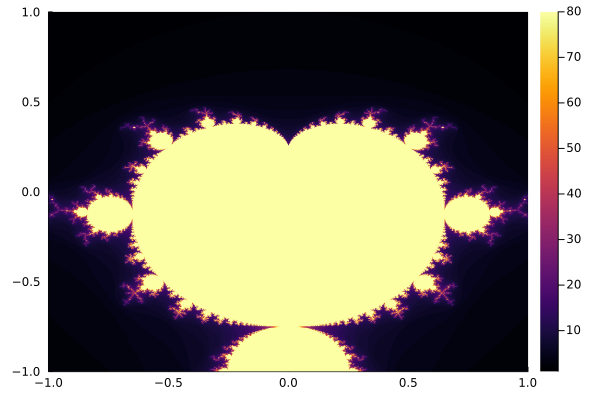

In [27]:
using Plots

n = 1000
xrange = (-1.0, 1.0)
yrange = (-1.0, 1.0)
x = LinRange(xrange[1], yrange[2], n)
y = LinRange(yrange[1], yrange[2], n)
z = mandel_grid(xrange=xrange, yrange=yrange, n=n)

heatmap(x, y, z)

Zooming in to a specific spot:

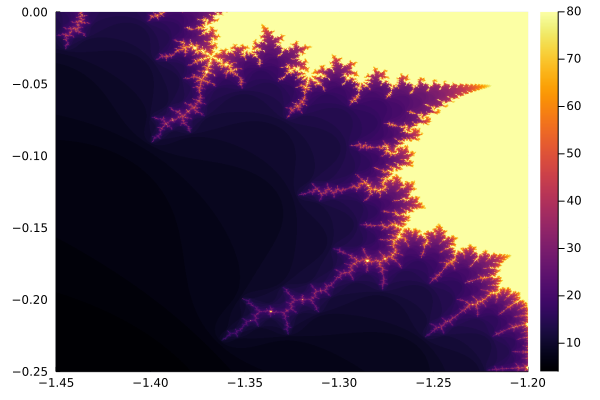

In [28]:
n = 1000
xrange = (-1.45, -1.20)
yrange = (-0.25, 0.0)
x = LinRange(xrange[1], xrange[2], n)
y = LinRange(yrange[1], yrange[2], n)
z = mandel_grid(xrange=xrange, yrange=yrange, n=n)

heatmap(x, y, z)

##### KR6: Plot of the time it takes for the function to run using `@time` macro for the given grid size `n`.

I used `@elapsed` so I can extract the time in seconds since I can assign it to a variable.

In [29]:
@elapsed mandel_grid()

0.004806154

In [30]:
@time mandel_grid()

  0.007881 seconds (2 allocations: 78.203 KiB)


100×100 Matrix{Float64}:
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  …  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  …  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  3.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  3.0  3.0     3.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  3.0  3.0     3.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  3.0  3.0  3.0  …  3.0  3.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  3.0  3.0  3.0  3.0     3.0  3.0  3.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  3.0  3.0  3.0  3.0  3.0

I run gridsizes for differen 2^n values just to cover ground quicker.

In [31]:
iter = 14
n_list = 2 .^ round.(Int64, 
                     (LinRange(1, iter, iter))
                    )

14-element Vector{Int64}:
     2
     4
     8
    16
    32
    64
   128
   256
   512
  1024
  2048
  4096
  8192
 16384

In [32]:
elapsed = Array{Float64}(undef, iter)
for i in 1:iter
    elapsed[i] = @elapsed mandel_grid(n=n_list[i])
end
elapsed

14-element Vector{Float64}:
   0.021363124
   1.4215e-5
   2.569e-5
   0.000111479
   0.000452867
   0.001795561
   0.008040005
   0.03193065
   0.114736369
   0.47119516
   2.062564557
   7.564541668
  33.282219048
 156.832726844

Plotting n vs time, it seems like the computational complexity is polynomial in time.

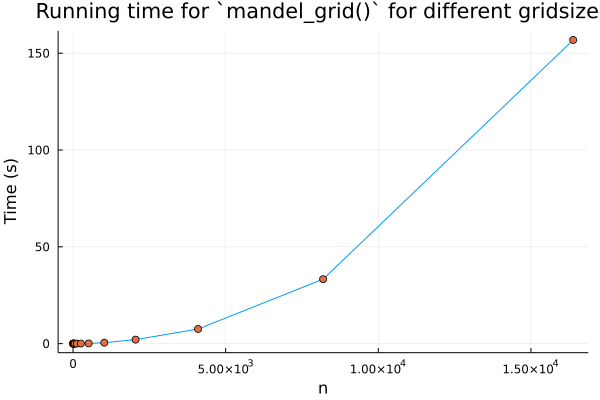

In [33]:
plot(n_list, elapsed, label=false)
scatter!(n_list, 
        elapsed,
        xlabel="n",
        ylabel="Time (s)",
        title="Running time for `mandel_grid()` for different gridsizes",
        label=false)

However, I realized that the x-axis might probably not need to be n but $n^2$. Squaring the x-axis, we see that it looks like it's actually linear.

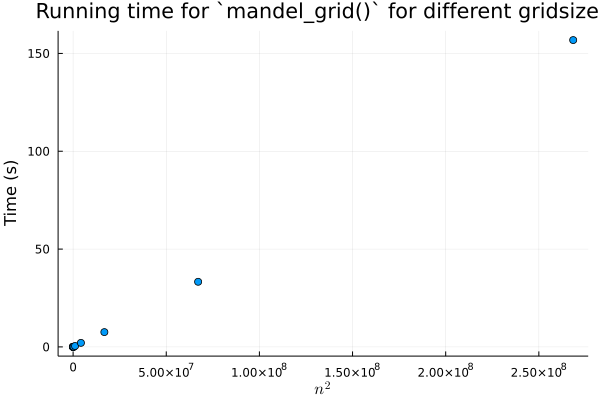

In [40]:
using LaTeXStrings

scatter(n_list.^2, 
        elapsed,
        xlabel=L"n^2",
        ylabel="Time (s)",
        title="Running time for `mandel_grid()` for different gridsizes",
        label=false)

###### KR7: Discuss the computational complexity of the Madelbrot function you made based onKR5.  What is the best `@time` output to use for this?

As mentioned above the best `@time` macro for this time was `@elapsed`.

Based on the previous two plots, the computational complexity of the Mandelbrot function seems to be linear as a function of actual number of elements in the grid; As a function of the parameter n (length of one side of a square grid), it seems to be at least a polynomial of order 2 based on the magnitudes of n and the coefficients.

In [35]:
using Polynomials

In [36]:
fit(n_list.^2, elapsed, 1)

Polynomial(-0.5419134718089813 + 5.810852347419767e-7*x)

In [37]:
fit(n_list, elapsed, 2)

Polynomial(0.31679617622177886 - 0.0011314560859559033*x + 6.510779124230988e-7*x^2)

In [38]:
fit(n_list, elapsed, 3)

Polynomial(0.0010578525609596418 + 7.233792448958852e-5*x + 3.935586264020012e-7*x^2 + 1.1369421312555185e-11*x^3)